In [3]:
pip install imutils 

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=03e1b195b9a000787396c398af0bfb5ffe73c8b8ff0d0b0757b3c75c55125466
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f5\0c\3a\61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import cv2 
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [7]:
IMG_PATH = './brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 211
Validation set size: 71
Test set size: 9


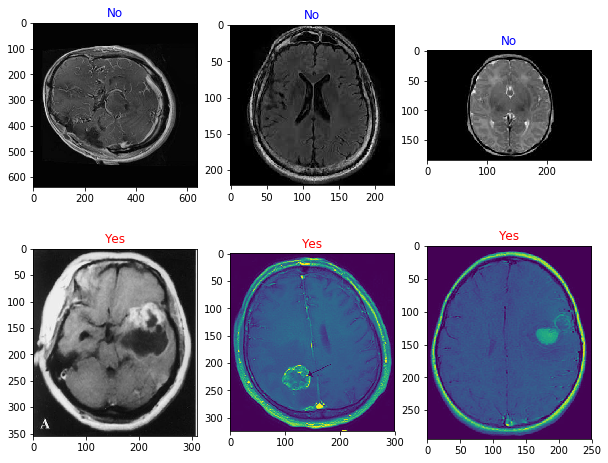

In [8]:
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

In [9]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [10]:
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [11]:
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

W0516 17:14:33.145201 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.156207 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.167206 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.179232 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.190232 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.201202 10140 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0516 17:14:33.213199 10140 image.py:656] Clipping input data to the valid range for ims

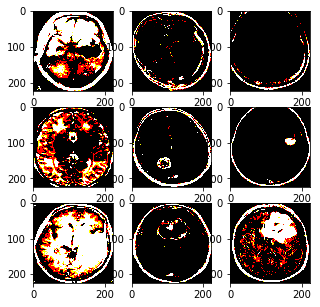

In [13]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

In [4]:
import os
import numpy as np
import cv2 
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

IMG_PATH = './brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
        axs[i, j].set_yticklabels([])  # Remove y-axis tick labels
plt.show()


C:\Users\user\anaconda3\envs\MRI\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\MRI\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\MRI\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\envs\MRI\lib\site-packages\tensorflow\python\framework\dty

Train set size: 211
Validation set size: 71
Test set size: 9


<Figure size 1000x800 with 6 Axes>